In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

api_token = os.environ.get('EODHD_API_TOKEN')

magnificent_seven = [
    'AAPL.US',  # Apple
    'MSFT.US',  # Microsoft
    'GOOGL.US', # Alphabet (Google)
    'AMZN.US',  # Amazon
    'META.US',  # Meta (Facebook)
    'TSLA.US',  # Tesla
    'NVDA.US',   # NVIDIA
    'AVGO.US' #AVGO
]

In [3]:
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = '2023-06-01'

# Function to fetch data for a single ticker
def fetch_stock_data(ticker):
    url = f'https://eodhd.com/api/eod/{ticker}'
    query = {
        'api_token': api_token,
        'fmt': 'json',
        'from': start_date,
        'to': end_date
    }

    response = requests.get(url, params=query)
    if response.status_code != 200:
        print(f"Error fetching data for {ticker}: {response.status_code}")
        print(response.text)
        return None

    data = response.json()
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)  # Ensure data is sorted by date
    return df

# Create an empty DataFrame to store adjusted close prices
all_adj_close = pd.DataFrame()

# Fetch data for each ticker and add to the DataFrame
for ticker in magnificent_seven:
    stock_data = fetch_stock_data(ticker)
    if stock_data is not None:
        # Extract ticker symbol without exchange suffix for column name
        symbol = ticker.split('.')[0]
        all_adj_close[symbol] = stock_data['adjusted_close']
    else:
        print(f"{ticker}  - Failed to get data")

all_adj_close.head()

,AAPL,MSFT,GOOGL,AMZN,META,TSLA,NVDA,AVGO
date,,,,,,,,
2023-06-01,178.3048,327.4877,123.1313,122.77,271.3312,207.52,39.7471,76.5276
2023-06-02,179.1562,330.2645,124.0768,124.25,271.3312,213.97,39.3044,78.6637
2023-06-05,177.7998,330.7963,125.4104,125.30,270.1169,217.61,39.1485,77.7240
2023-06-06,177.4335,328.5709,126.7042,126.61,269.8482,221.31,38.6318,76.5324
2023-06-07,176.0573,318.4286,121.9171,121.23,262.3635,224.57,37.4573,76.7872


# Correlations

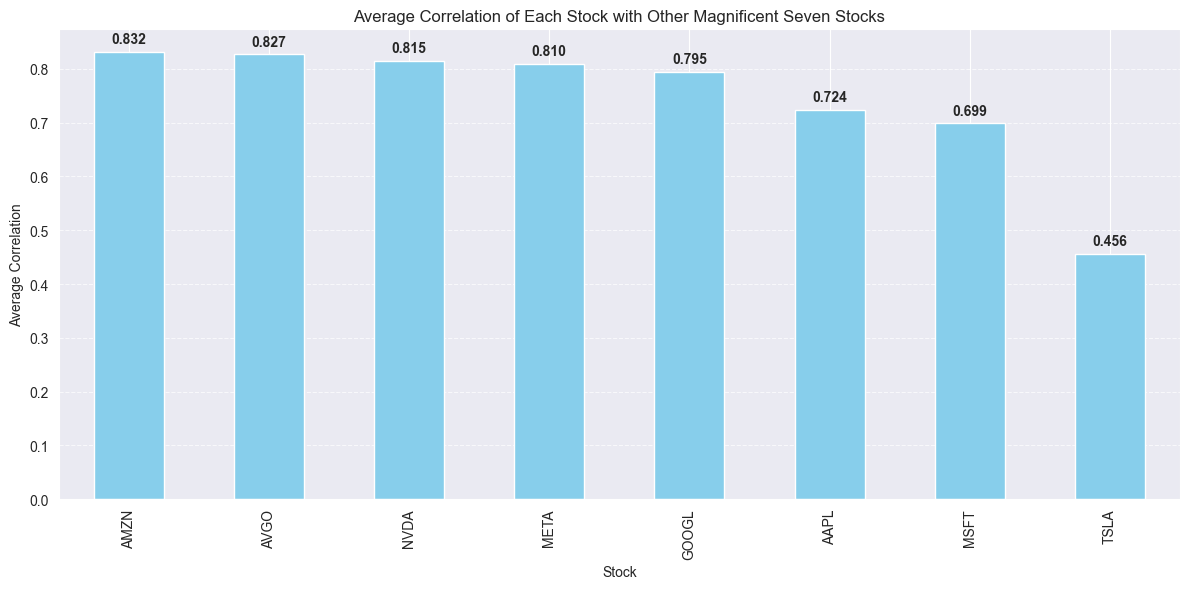

In [4]:
# Calculate correlation matrix
correlation_matrix = all_adj_close.corr()

# Convert correlation matrix to long format and sort
corr_df = correlation_matrix.unstack()
corr_df = pd.DataFrame(corr_df, columns=['correlation'])
corr_df.index.names = ['stock1', 'stock2']
corr_df = corr_df.reset_index()
corr_df = corr_df[corr_df['stock1'] != corr_df['stock2']]  # Remove self correlations
corr_df = corr_df[corr_df['stock1'] < corr_df['stock2']] # Keep only one pair by ensuring stock1 comes before stock2 alphabetically

# Calculate average correlation for each stock
# First, create a new dataframe that includes all correlations for each stock
all_stock_corrs = pd.DataFrame()

# Combine correlations where the stock appears in either stock1 or stock2
for stock in all_adj_close.columns:
    # Get correlations where stock is in stock1
    stock1_corrs = corr_df[corr_df['stock1'] == stock][['stock2', 'correlation']]
    stock1_corrs.columns = ['other_stock', 'correlation']

    # Get correlations where stock is in stock2
    stock2_corrs = corr_df[corr_df['stock2'] == stock][['stock1', 'correlation']]
    stock2_corrs.columns = ['other_stock', 'correlation']

    # Combine both sets of correlations
    stock_corrs = pd.concat([stock1_corrs, stock2_corrs])

    # Calculate average correlation for this stock
    avg_corr = stock_corrs['correlation'].mean()

    # Add to the results dataframe
    all_stock_corrs.loc[stock, 'avg_correlation'] = avg_corr

# Sort by average correlation
all_stock_corrs = all_stock_corrs.sort_values('avg_correlation', ascending=False)

# Plot the average correlations as a bar chart
plt.figure(figsize=(12, 6))
ax = all_stock_corrs['avg_correlation'].plot(kind='bar', color='skyblue')
plt.title('Average Correlation of Each Stock with Other Magnificent Seven Stocks')
plt.ylabel('Average Correlation')
plt.xlabel('Stock')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(all_stock_corrs['avg_correlation']):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Equal Weight Strategy

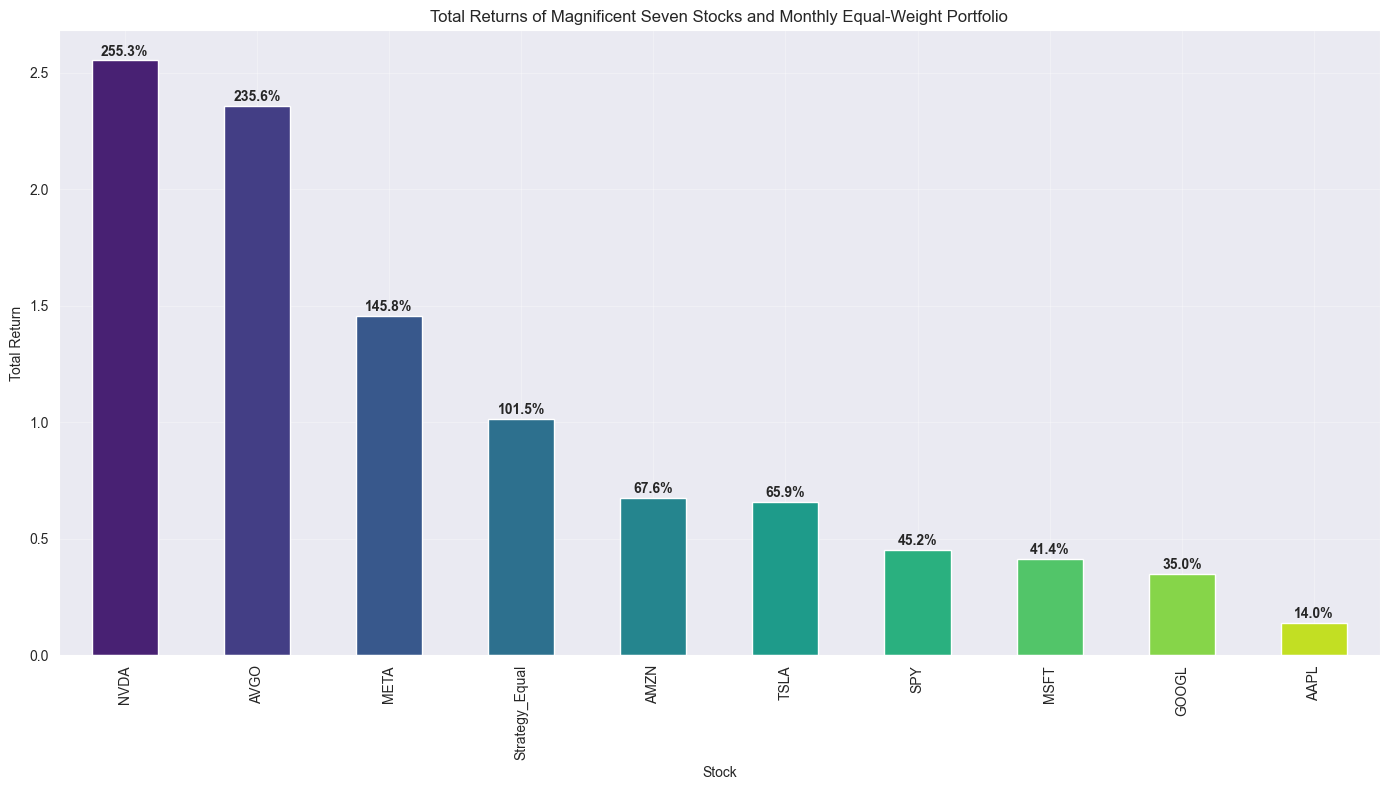

In [5]:
def monthly_equal_weight_strategy(prices_df, initial_capital=10000):
    # Create a copy of the dataframe to avoid modifying the original
    df = prices_df.copy()

    # Get list of stocks
    stocks = df.columns.tolist()
    num_stocks = len(stocks)

    # Create a dataframe to store portfolio values
    portfolio_df = pd.DataFrame(index=df.index)

    # Add price columns for reference
    for stock in stocks:
        portfolio_df[f'{stock}_price'] = df[stock]

    # Initialize portfolio tracking variables
    portfolio_df['month'] = portfolio_df.index.to_period('M')
    portfolio_df['is_month_start'] = portfolio_df.index.is_month_start

    # For dates that aren't the first of the month, use the first available trading day
    first_trading_days = []
    for month in portfolio_df['month'].unique():
        month_data = portfolio_df[portfolio_df['month'] == month]
        first_trading_days.append(month_data.index[0])

    portfolio_df['is_rebalance_day'] = portfolio_df.index.isin(first_trading_days)

    # Initialize holdings and shares columns
    for stock in stocks:
        portfolio_df[f'{stock}_shares'] = 0
        portfolio_df[f'{stock}_value'] = 0

    portfolio_df['cash'] = initial_capital
    portfolio_df['portfolio_value'] = initial_capital

    # Implement the strategy
    for i, date in enumerate(portfolio_df.index):
        if i == 0:
            # First day - invest equal amount in each stock
            amount_per_stock = initial_capital / num_stocks
            for stock in stocks:
                price = portfolio_df.loc[date, f'{stock}_price']
                shares = amount_per_stock / price
                portfolio_df.loc[date, f'{stock}_shares'] = shares
                portfolio_df.loc[date, f'{stock}_value'] = shares * price

            portfolio_df.loc[date, 'cash'] = 0
            portfolio_df.loc[date, 'portfolio_value'] = sum(portfolio_df.loc[date, f'{stock}_value'] for stock in stocks)

        elif portfolio_df.loc[date, 'is_rebalance_day']:
            # Rebalance day - sell all shares and reinvest equally
            current_value = portfolio_df.iloc[i-1]['portfolio_value']
            amount_per_stock = current_value / num_stocks

            for stock in stocks:
                price = portfolio_df.loc[date, f'{stock}_price']
                shares = amount_per_stock / price
                portfolio_df.loc[date, f'{stock}_shares'] = shares
                portfolio_df.loc[date, f'{stock}_value'] = shares * price

            portfolio_df.loc[date, 'cash'] = 0
            portfolio_df.loc[date, 'portfolio_value'] = sum(portfolio_df.loc[date, f'{stock}_value'] for stock in stocks)

        else:
            # Regular day - update values based on price changes
            for stock in stocks:
                # Carry forward shares from previous day
                portfolio_df.loc[date, f'{stock}_shares'] = portfolio_df.iloc[i-1][f'{stock}_shares']
                # Update value based on current price
                price = portfolio_df.loc[date, f'{stock}_price']
                portfolio_df.loc[date, f'{stock}_value'] = portfolio_df.loc[date, f'{stock}_shares'] * price

            # Carry forward cash
            portfolio_df.loc[date, 'cash'] = portfolio_df.iloc[i-1]['cash']
            # Update portfolio value
            portfolio_df.loc[date, 'portfolio_value'] = sum(portfolio_df.loc[date, f'{stock}_value'] for stock in stocks) + portfolio_df.loc[date, 'cash']

    return portfolio_df




# Run the strategy
initial_capital = 10000
portfolio_results = monthly_equal_weight_strategy(all_adj_close, initial_capital)

portfolio_results.to_csv('csv/resutls.csv')

# Calculate daily returns for each stock
stock_returns = all_adj_close.pct_change().dropna()

# Calculate daily returns for the portfolio
portfolio_returns = portfolio_results['portfolio_value'].pct_change().dropna()

# Calculate cumulative returns
stock_cumulative_returns = (1 + stock_returns).cumprod() - 1
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Calculate total return for each stock and the portfolio
total_stock_returns = stock_cumulative_returns.iloc[-1]
portfolio_total_return = portfolio_cumulative_returns.iloc[-1]

# Calculate total return for SPY
spy_data = fetch_stock_data('SPY.US')
spy_returns = spy_data['adjusted_close'].pct_change().dropna()
spy_cumulative_returns = (1 + spy_returns).cumprod() - 1
spy_total_return = spy_cumulative_returns.iloc[-1]

# Prepare data for the bar chart
total_returns_with_portfolio = total_stock_returns.copy()
total_returns_with_portfolio['Strategy_Equal'] = portfolio_total_return
total_returns_with_portfolio['SPY'] = spy_total_return

# Sort the returns in descending order
sorted_returns = total_returns_with_portfolio.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(14, 8))
ax = sorted_returns.plot(kind='bar', color=sns.color_palette("viridis", len(sorted_returns)))
plt.title('Total Returns of Magnificent Seven Stocks and Monthly Equal-Weight Portfolio')
plt.xlabel('Stock')
plt.ylabel('Total Return')
plt.grid(True, alpha=0.3)

# Add value labels on top of each bar
for i, v in enumerate(sorted_returns):
    ax.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

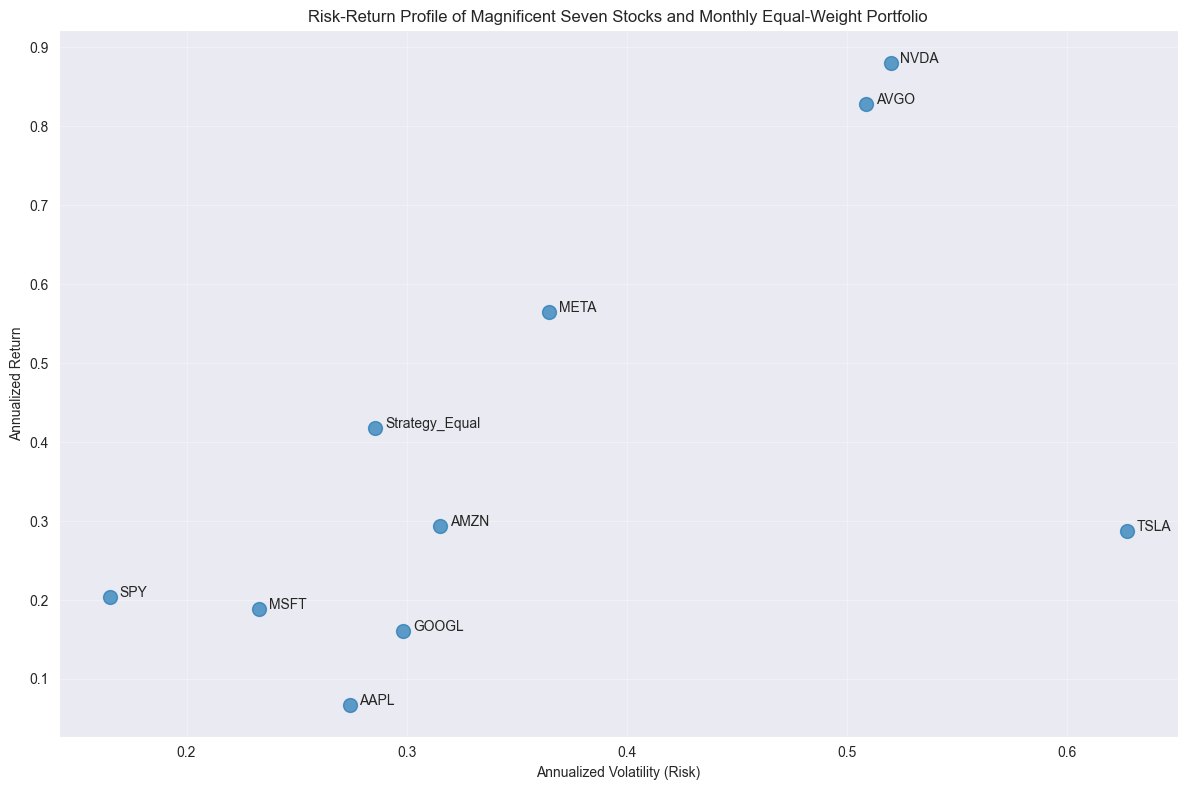

In [6]:
# Calculate annualized returns
years = (all_adj_close.index.max() - all_adj_close.index.min()).days / 365.25
annualized_stock_returns = (1 + total_stock_returns) ** (1 / years) - 1
portfolio_annualized_return = (1 + portfolio_total_return) ** (1 / years) - 1
spy_annualized_return = (1 + spy_total_return) ** (1 / years) - 1

# Calculate annualized volatility
annualized_stock_volatility = stock_returns.std() * np.sqrt(252)  # Assuming 252 trading days per year
portfolio_annualized_volatility = portfolio_returns.std() * np.sqrt(252)
spy_annualized_volatility = spy_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio (assuming risk-free rate of 0% for simplicity)
sharpe_ratio_stocks = annualized_stock_returns / annualized_stock_volatility
portfolio_sharpe_ratio = portfolio_annualized_return / portfolio_annualized_volatility
spy_sharpe_ratio = spy_annualized_return / spy_annualized_volatility

# Create a performance summary DataFrame
performance_summary = pd.DataFrame({
    'Total Return': pd.Series({**total_stock_returns, 'Strategy_Equal': portfolio_total_return, 'SPY': spy_annualized_return}),
    'Annualized Return': pd.Series({**annualized_stock_returns, 'Strategy_Equal': portfolio_annualized_return, 'SPY': spy_annualized_return}),
    'Annualized Volatility': pd.Series({**annualized_stock_volatility, 'Strategy_Equal': portfolio_annualized_volatility, 'SPY': spy_annualized_volatility}),
    'Sharpe Ratio': pd.Series({**sharpe_ratio_stocks, 'Strategy_Equal': portfolio_sharpe_ratio, 'SPY': spy_sharpe_ratio}),
})

# Sort by total return
performance_summary = performance_summary.sort_values('Total Return', ascending=False)

# Plot the risk-return scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    performance_summary['Annualized Volatility'],
    performance_summary['Annualized Return'],
    s=100, alpha=0.7
)

# Add labels for each point
for i, txt in enumerate(performance_summary.index):
    plt.annotate(
        txt,
        (performance_summary['Annualized Volatility'].iloc[i], performance_summary['Annualized Return'].iloc[i]),
        xytext=(7, 0), textcoords='offset points'
    )

plt.title('Risk-Return Profile of Magnificent Seven Stocks and Monthly Equal-Weight Portfolio')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# EPS Weighted Strategy

In [7]:
# Function to get annual EPS data for a ticker
def get_annual_eps(ticker):
    url = f'https://eodhd.com/api/fundamentals/{ticker}'
    query = {'api_token': api_token, "fmt": "json"}
    response = requests.get(url, params=query)

    if response.status_code != 200:
        print(f"Error fetching data for {ticker}: {response.status_code}")
        print(response.text)
        return None

    data = response.json()

    # Extract annual EPS data
    if 'Earnings' in data and 'Annual' in data['Earnings']:
        eps_data = data['Earnings']['Annual']
        # Convert to DataFrame
        eps_df = pd.DataFrame([
            {'date': key, 'epsActual': value['epsActual']}
            for key, value in eps_data.items()
        ])
        eps_df['date'] = pd.to_datetime(eps_df['date'])
        eps_df = eps_df.sort_values('date', ascending=False)
        eps_df.set_index('date', inplace=True)
        return eps_df
    else:
        print(f"No annual EPS data found for {ticker}")
        return None

# Get annual EPS for each stock
annual_eps = {}
for ticker in magnificent_seven:
    symbol = ticker.split('.')[0]  # Extract ticker symbol without exchange suffix
    eps_data = get_annual_eps(ticker)
    if eps_data is not None:
        annual_eps[symbol] = eps_data

In [8]:
def monthly_eps_weight_strategy(prices_df, eps_data, initial_capital=10000):
    # Create a copy of the dataframe to avoid modifying the original
    df = prices_df.copy()

    # Get list of stocks
    stocks = df.columns.tolist()
    num_stocks = len(stocks)

    # Create a dataframe to store portfolio values
    portfolio_df = pd.DataFrame(index=df.index)

    # Add price columns for reference
    for stock in stocks:
        portfolio_df[f'{stock}_price'] = df[stock]

    # Initialize portfolio tracking variables
    portfolio_df['month'] = portfolio_df.index.to_period('M')
    portfolio_df['is_month_start'] = portfolio_df.index.is_month_start

    # For dates that aren't the first of the month, use the first available trading day
    first_trading_days = []
    for month in portfolio_df['month'].unique():
        month_data = portfolio_df[portfolio_df['month'] == month]
        first_trading_days.append(month_data.index[0])

    portfolio_df['is_rebalance_day'] = portfolio_df.index.isin(first_trading_days)

    # Initialize holdings and shares columns
    for stock in stocks:
        portfolio_df[f'{stock}_shares'] = 0
        portfolio_df[f'{stock}_value'] = 0
        portfolio_df[f'{stock}_weight'] = 0

    portfolio_df['cash'] = initial_capital
    portfolio_df['portfolio_value'] = initial_capital

    # Function to calculate EPS-based weights
    def calculate_eps_weights(date, available_stocks):
        # Get the most recent EPS for each stock as of the date
        month_eps = {}
        for ticker in available_stocks:
            if ticker in eps_data:
                # Get the most recent EPS data available before the date
                recent_eps = eps_data[ticker].loc[eps_data[ticker].index <= date]
                if not recent_eps.empty:
                    month_eps[ticker] = recent_eps.iloc[0]['epsActual']
                else:
                    # If no EPS data is available before this date, use the earliest available
                    month_eps[ticker] = eps_data[ticker].iloc[-1]['epsActual']
            else:
                month_eps[ticker] = 0

        # Convert to Series for easier manipulation
        month_eps_series = pd.Series(month_eps)

        # Handle negative EPS values by setting them to a small positive number
        month_eps_series[month_eps_series <= 0] = 0.01

        # Calculate total EPS
        total_eps = month_eps_series.sum()

        # Calculate weights
        if total_eps > 0:
            weights = month_eps_series / total_eps
        else:
            # If all EPS values are 0 or negative, use equal weights
            weights = pd.Series({ticker: 1/len(available_stocks) for ticker in available_stocks})

        return weights

    # Implement the strategy
    for i, date in enumerate(portfolio_df.index):
        if i == 0:
            # First day - invest based on EPS weights
            weights = calculate_eps_weights(date, stocks)

            for stock in stocks:
                weight = weights.get(stock, 0)
                portfolio_df.loc[date, f'{stock}_weight'] = weight

                amount = initial_capital * weight
                price = portfolio_df.loc[date, f'{stock}_price']
                shares = amount / price

                portfolio_df.loc[date, f'{stock}_shares'] = shares
                portfolio_df.loc[date, f'{stock}_value'] = shares * price

            portfolio_df.loc[date, 'cash'] = 0
            portfolio_df.loc[date, 'portfolio_value'] = sum(portfolio_df.loc[date, f'{stock}_value'] for stock in stocks)

        elif portfolio_df.loc[date, 'is_rebalance_day']:
            # Rebalance day - sell all shares and reinvest based on EPS weights
            current_value = portfolio_df.iloc[i-1]['portfolio_value']
            weights = calculate_eps_weights(date, stocks)

            for stock in stocks:
                weight = weights.get(stock, 0)
                portfolio_df.loc[date, f'{stock}_weight'] = weight

                amount = current_value * weight
                price = portfolio_df.loc[date, f'{stock}_price']
                shares = amount / price

                portfolio_df.loc[date, f'{stock}_shares'] = shares
                portfolio_df.loc[date, f'{stock}_value'] = shares * price

            portfolio_df.loc[date, 'cash'] = 0
            portfolio_df.loc[date, 'portfolio_value'] = sum(portfolio_df.loc[date, f'{stock}_value'] for stock in stocks)

        else:
            # Regular day - update values based on price changes
            for stock in stocks:
                # Carry forward shares and weights from previous day
                portfolio_df.loc[date, f'{stock}_shares'] = portfolio_df.iloc[i-1][f'{stock}_shares']
                portfolio_df.loc[date, f'{stock}_weight'] = portfolio_df.iloc[i-1][f'{stock}_weight']

                # Update value based on current price
                price = portfolio_df.loc[date, f'{stock}_price']
                portfolio_df.loc[date, f'{stock}_value'] = portfolio_df.loc[date, f'{stock}_shares'] * price

            # Carry forward cash
            portfolio_df.loc[date, 'cash'] = portfolio_df.iloc[i-1]['cash']
            # Update portfolio value
            portfolio_df.loc[date, 'portfolio_value'] = sum(portfolio_df.loc[date, f'{stock}_value'] for stock in stocks) + portfolio_df.loc[date, 'cash']

    return portfolio_df

# Run the EPS-weighted strategy
initial_capital = 10000  # $10,000 initial investment
eps_portfolio_results = monthly_eps_weight_strategy(all_adj_close, annual_eps, initial_capital)

# Calculate daily returns for the portfolio
eps_portfolio_returns = eps_portfolio_results['portfolio_value'].pct_change().dropna()

# Calculate cumulative returns
eps_portfolio_cumulative_returns = (1 + eps_portfolio_returns).cumprod() - 1

# Calculate total return for the portfolio
eps_portfolio_total_return = eps_portfolio_cumulative_returns.iloc[-1]

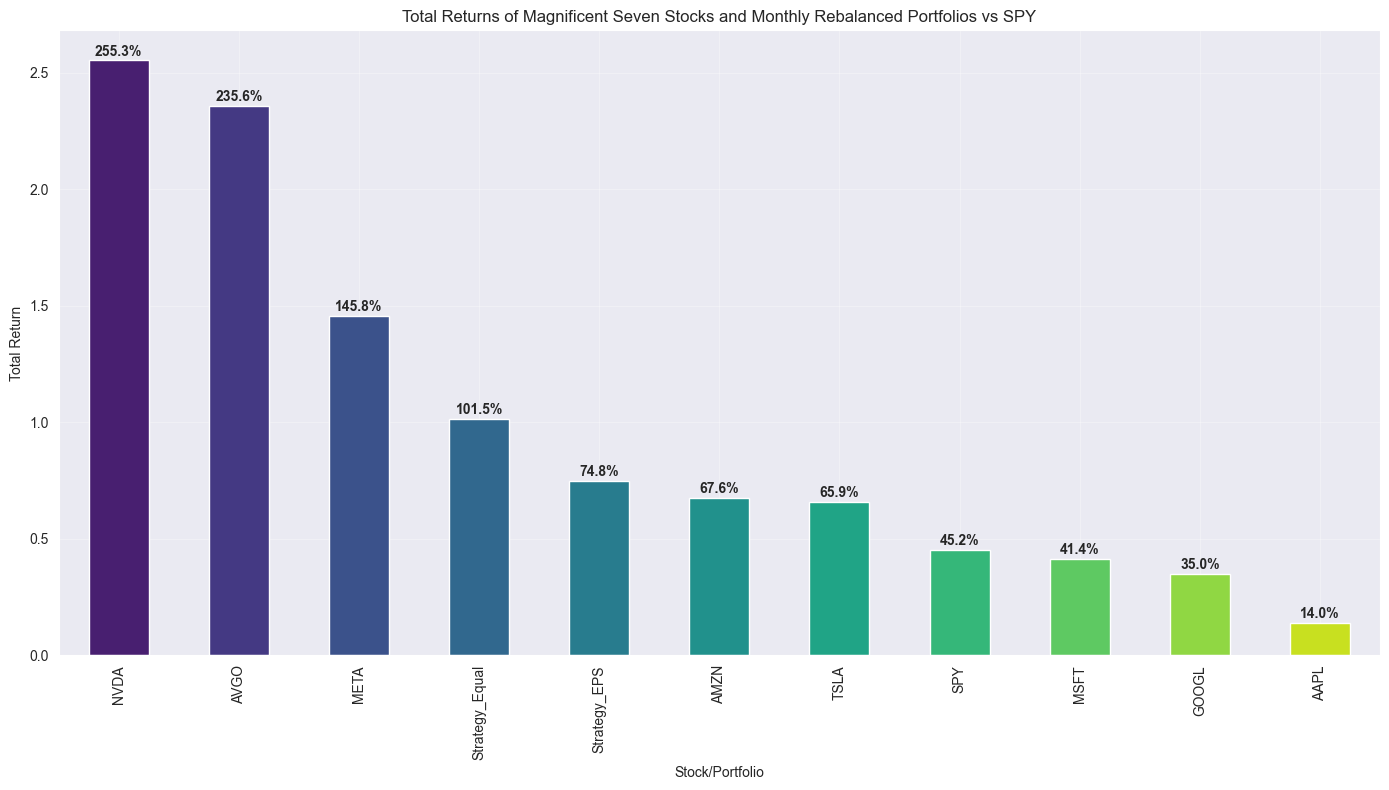

In [9]:
# Prepare data for the bar chart
total_returns_with_portfolios = total_stock_returns.copy()
total_returns_with_portfolios['Strategy_Equal'] = portfolio_total_return
total_returns_with_portfolios['Strategy_EPS'] = eps_portfolio_total_return
total_returns_with_portfolios['SPY'] = spy_total_return  # Add SPY for comparison

# Sort the returns in descending order
sorted_returns = total_returns_with_portfolios.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(14, 8))
ax = sorted_returns.plot(kind='bar', color=sns.color_palette("viridis", len(sorted_returns)))
plt.title('Total Returns of Magnificent Seven Stocks and Monthly Rebalanced Portfolios vs SPY')
plt.xlabel('Stock/Portfolio')
plt.ylabel('Total Return')
plt.grid(True, alpha=0.3)

# Add value labels on top of each bar
for i, v in enumerate(sorted_returns):
    ax.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

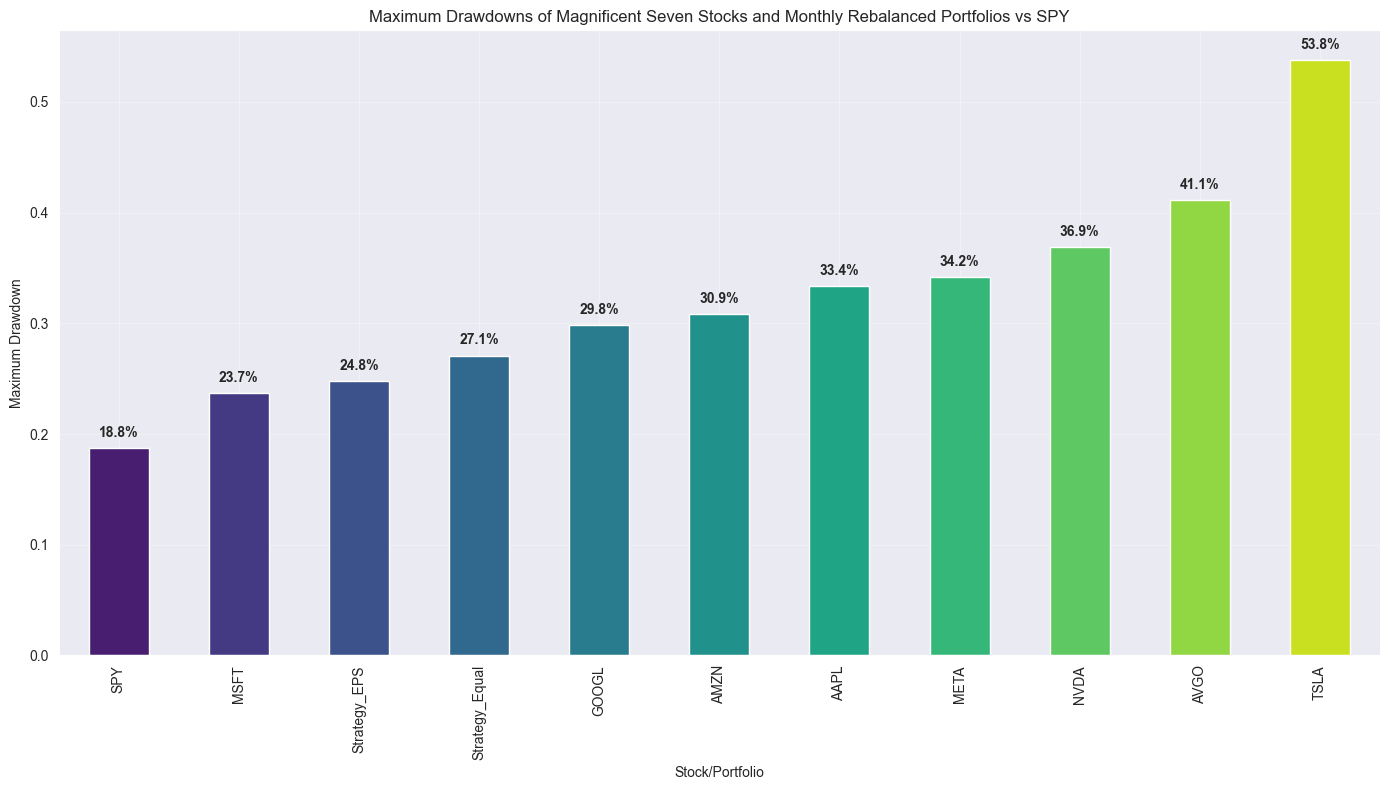

In [10]:
# Function to calculate maximum drawdown
def calculate_max_drawdown(returns):
    # Calculate cumulative returns
    cum_returns = (1 + returns).cumprod()

    # Calculate running maximum
    running_max = cum_returns.cummax()

    # Calculate drawdown
    drawdown = (cum_returns / running_max) - 1

    # Get the maximum drawdown (minimum of drawdown)
    max_drawdown = drawdown.min()

    # Return as positive percentage (absolute value)
    return abs(max_drawdown)

# Calculate maximum drawdown for each stock
stock_max_drawdowns = {}
for stock in all_adj_close.columns:
    stock_returns_series = stock_returns[stock]
    stock_max_drawdowns[stock] = calculate_max_drawdown(stock_returns_series)

# Calculate maximum drawdown for the equal-weighted portfolio
equal_weight_max_drawdown = calculate_max_drawdown(portfolio_returns)

# Calculate maximum drawdown for the EPS-weighted portfolio
eps_weight_max_drawdown = calculate_max_drawdown(eps_portfolio_returns)

# Calculate maximum drawdown for SPY
spy_max_drawdown = calculate_max_drawdown(spy_returns)

# Prepare data for the bar chart
max_drawdowns = pd.Series(stock_max_drawdowns)
max_drawdowns['Strategy_Equal'] = equal_weight_max_drawdown
max_drawdowns['Strategy_EPS'] = eps_weight_max_drawdown
max_drawdowns['SPY'] = spy_max_drawdown  # Add SPY for comparison

# Sort the drawdowns in ascending order (smaller drawdowns are better)
sorted_drawdowns = max_drawdowns.sort_values()

# Create a bar chart
plt.figure(figsize=(14, 8))
ax = sorted_drawdowns.plot(kind='bar', color=sns.color_palette("viridis", len(sorted_drawdowns)))
plt.title('Maximum Drawdowns of Magnificent Seven Stocks and Monthly Rebalanced Portfolios vs SPY')
plt.xlabel('Stock/Portfolio')
plt.ylabel('Maximum Drawdown')
plt.grid(True, alpha=0.3)

# Add value labels on top of each bar
for i, v in enumerate(sorted_drawdowns):
    ax.text(i, v + 0.01, f'{v*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

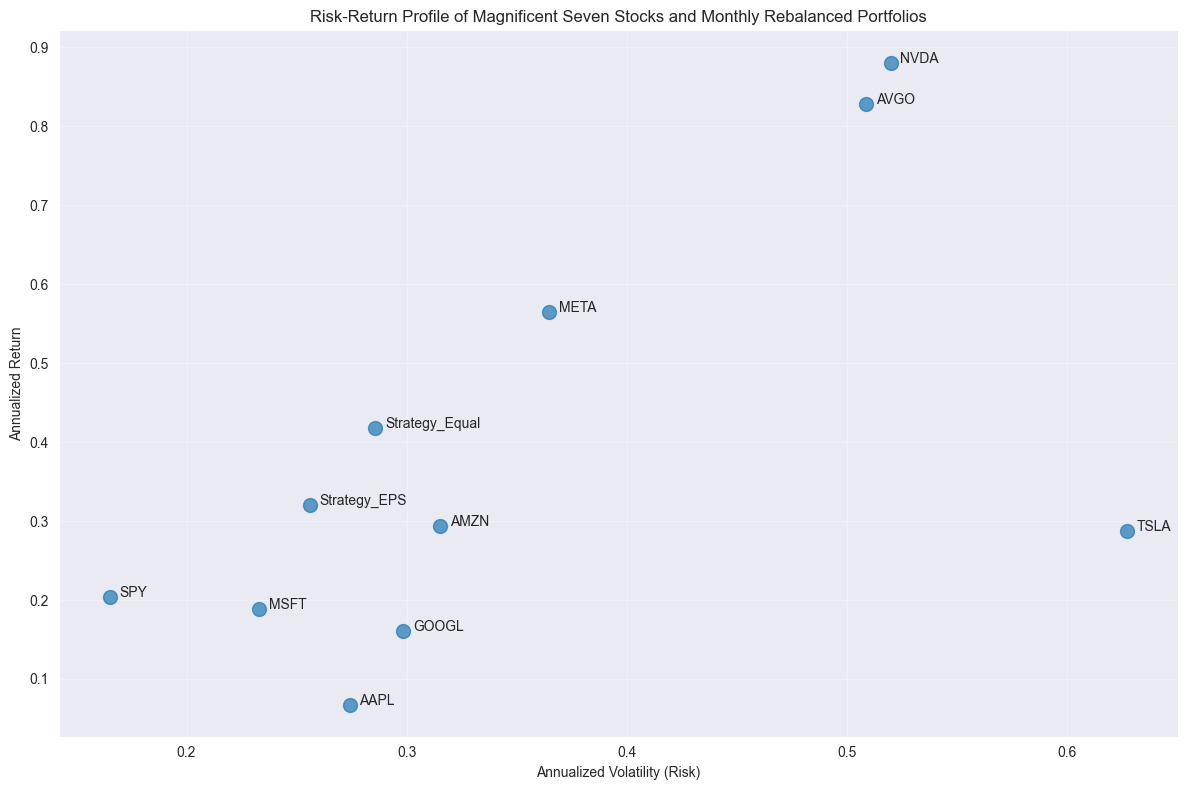

In [11]:
# Calculate annualized return and volatility for the EPS weighted strategy
eps_portfolio_annualized_return = (1 + eps_portfolio_total_return) ** (1 / years) - 1
eps_portfolio_annualized_volatility = eps_portfolio_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio for the EPS weighted strategy
eps_portfolio_sharpe_ratio = eps_portfolio_annualized_return / eps_portfolio_annualized_volatility

# Create a performance summary DataFrame including both strategies
performance_summary_both = pd.DataFrame({
    'Total Return': pd.Series({**total_stock_returns, 'Strategy_Equal': portfolio_total_return, 'Strategy_EPS': eps_portfolio_total_return, 'SPY': spy_total_return}),
    'Annualized Return': pd.Series({**annualized_stock_returns, 'Strategy_Equal': portfolio_annualized_return, 'Strategy_EPS': eps_portfolio_annualized_return, 'SPY': spy_annualized_return}),
    'Annualized Volatility': pd.Series({**annualized_stock_volatility, 'Strategy_Equal': portfolio_annualized_volatility, 'Strategy_EPS': eps_portfolio_annualized_volatility, 'SPY': spy_annualized_volatility}),
    'Sharpe Ratio': pd.Series({**sharpe_ratio_stocks, 'Strategy_Equal': portfolio_sharpe_ratio, 'Strategy_EPS': eps_portfolio_sharpe_ratio, 'SPY': spy_sharpe_ratio}),
})

# Sort by total return
performance_summary_both = performance_summary_both.sort_values('Total Return', ascending=False)

# Plot the risk-return scatter plot for both strategies
plt.figure(figsize=(12, 8))
plt.scatter(
    performance_summary_both['Annualized Volatility'],
    performance_summary_both['Annualized Return'],
    s=100, alpha=0.7
)

# Add labels for each point
for i, txt in enumerate(performance_summary_both.index):
    plt.annotate(
        txt,
        (performance_summary_both['Annualized Volatility'].iloc[i], performance_summary_both['Annualized Return'].iloc[i]),
        xytext=(7, 0), textcoords='offset points'
    )

plt.title('Risk-Return Profile of Magnificent Seven Stocks and Monthly Rebalanced Portfolios')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
